#### Code based on the article: https://arxiv.org/abs/1903.10176

# Import libs

In [1]:
import os
from threading import Thread  # for running the denoiser in parallel
import queue

import numpy as np
import torch
import torch.optim
from models.skip import skip  # our network

from utils.utils import *  # auxiliary functions
from utils.data import Data  # class that holds img, psnr, time

from skimage.restoration import denoise_nl_means

In [2]:
# got GPU? - if you are not getting the exact article results set CUDNN to False
CUDA_FLAG = True
CUDNN = False 
if CUDA_FLAG:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    # GPU accelerated functionality for common operations in deep neural nets
    torch.backends.cudnn.enabled = CUDNN
    # benchmark mode is good whenever your input sizes for your network do not vary.
    # This way, cudnn will look for the optimal set of algorithms for that particular 
    # configuration (which takes some time). This usually leads to faster runtime.
    # But if your input sizes changes at each iteration, then cudnn will benchmark every
    # time a new size appears, possibly leading to worse runtime performances.
    torch.backends.cudnn.benchmark = CUDNN
    # torch.backends.cudnn.deterministic = True
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

# CONSTANCTS

In [3]:
SIGMA = 275
# graphs labels:
X_LABELS = ['Iterations']*3
Y_LABELS = ['PSNR between x and net (db)', 'PSNR with original image (db)', 'loss']

# Algorithm NAMES (to get the relevant image: use data_dict[alg_name].img)
# for example use data_dict['Clean'].img to get the clean image
ORIGINAL = 'Clean'
CORRUPTED = 'Noisy'
NLM = 'NLM'
DIP_NLM = 'DRED (NLM)'

# Load image for Denoising

In [4]:
def load_image(fclean, fnoisy=None, sigma=25, plot=False):
    """ 
        fname - input file name
        d - Make dimensions divisible by `d`
        sigma - the amount of noise you want to add noise to the image
        Return a numpy image, and a noisy numpy image with sigma selected
    """
    _, img_np = load_and_crop_image(fclean)
    if fnoisy is None:
        img_noisy_np = np.clip(img_np + np.random.normal(scale=sigma / 255., size=img_np.shape), 0, 1).astype(
            np.float32)
        # img_noisy_np = pil_to_np(np_to_pil(img_noisy_np)) # making it an image then loading it back to numpy
    else:
        _, img_noisy_np = load_and_crop_image(fnoisy)
    data_dict = {ORIGINAL: Data(img_np), CORRUPTED: Data(img_noisy_np, compare_psnr(img_np, img_noisy_np))}
    if plot:
        plot_dict(data_dict)
    return data_dict

D:\anaconda3\envs\deep-image-prior\lib\site-packages\ipykernel_launcher.py:15: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  from ipykernel import kernelapp as app


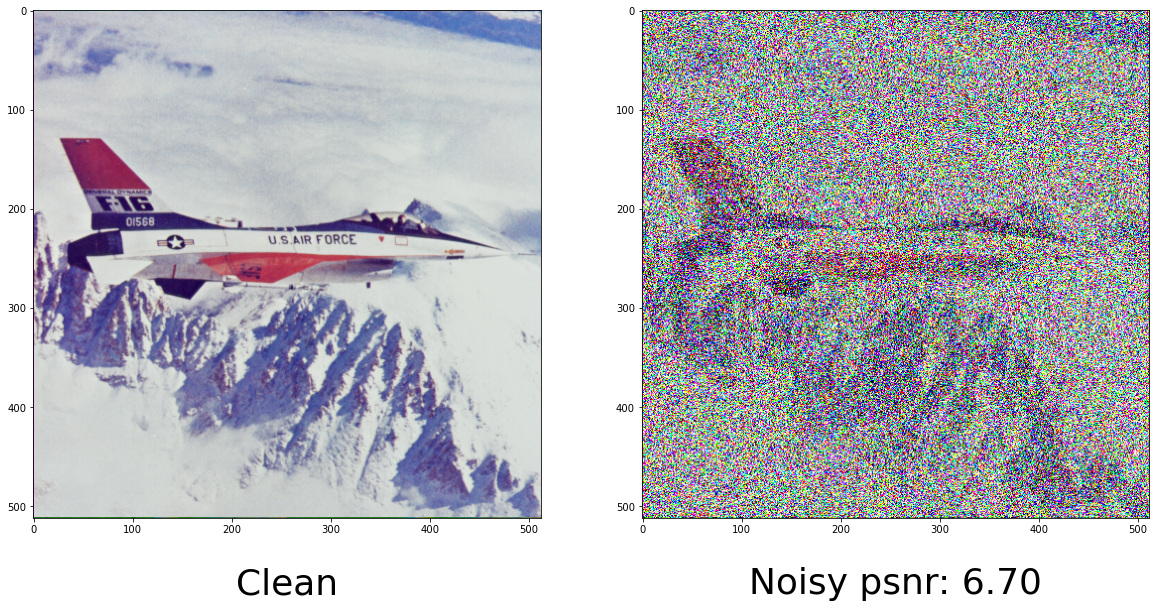

((3, 512, 512), dtype('float32'), 0.0, 1.0)

In [5]:
# load the image and add noise - for real use send same image file to fclean and fnoisy and ignore psnrs
data_dict1 = load_image('datasets/F16_GT.png', sigma=SIGMA, plot=True)
data_dict1[CORRUPTED].img.shape, data_dict1[CORRUPTED].img.dtype, np.min(data_dict1[CORRUPTED].img), np.max(data_dict1[CORRUPTED].img)

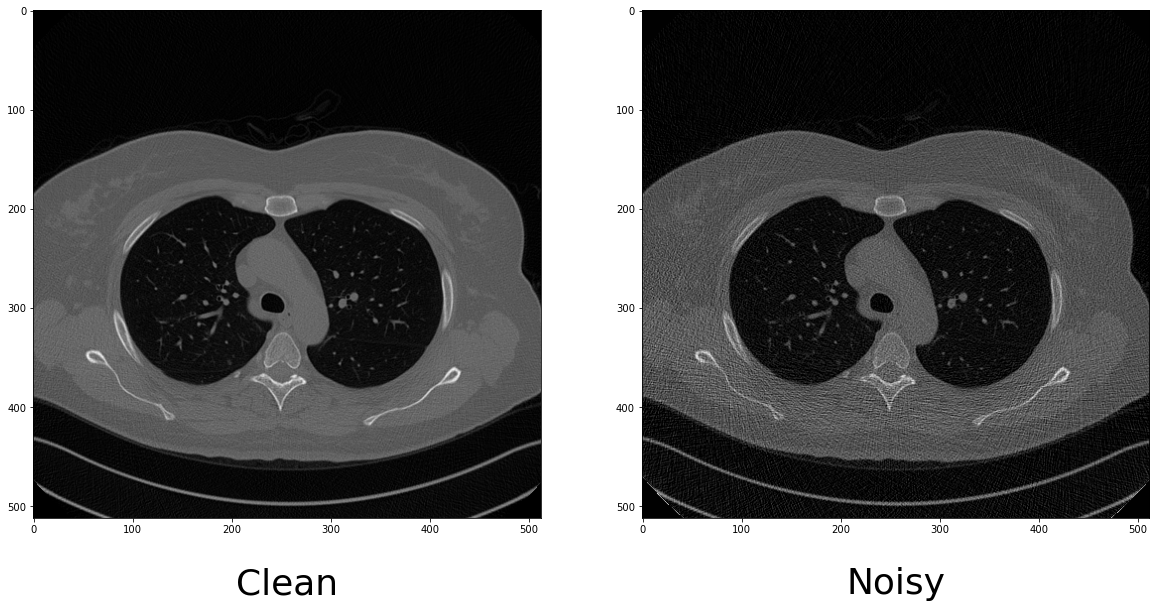

((1, 512, 512), dtype('float32'), 0.0, 0.71819293)

In [6]:
full_dose = np.load('./images_npy/C002_200_full.npy')[None, :].astype(np.float32) / 4095.
low_dose = np.load('./images_npy/C002_200_low.npy')[None, :].astype(np.float32) / 4095.
data_dict = {ORIGINAL: Data(full_dose), CORRUPTED: Data(low_dose)}
plot_dict(data_dict)
data_dict[CORRUPTED].img.shape, data_dict[CORRUPTED].img.dtype, np.min(data_dict[CORRUPTED].img), np.max(data_dict[CORRUPTED].img)

# THE NETWORK

In [7]:
def get_network_and_input(img_shape, input_depth=32, pad='reflection',
                          upsample_mode='bilinear', use_interpolate=True, align_corners=False,
                          act_fun='LeakyReLU', skip_n33d=128, skip_n33u=128, skip_n11=4,
                          num_scales=5, downsample_mode='stride', INPUT='noise'):  # 'meshgrid'
    """ Getting the relevant network and network input (based on the image shape and input depth)
        We are using the same default params as in DIP article
        img_shape - the image shape (ch, x, y)
    """
    n_channels = img_shape[0]
    net = skip(input_depth, n_channels,
               num_channels_down=[skip_n33d] * num_scales if isinstance(skip_n33d, int) else skip_n33d,
               num_channels_up=[skip_n33u] * num_scales if isinstance(skip_n33u, int) else skip_n33u,
               num_channels_skip=[skip_n11] * num_scales if isinstance(skip_n11, int) else skip_n11,
               upsample_mode=upsample_mode, use_interpolate=use_interpolate, align_corners=align_corners,
               downsample_mode=downsample_mode, need_sigmoid=True, need_bias=True, pad=pad, act_fun=act_fun).type(dtype)
    net_input = get_noise(input_depth, INPUT, img_shape[1:]).type(dtype).detach()
    return net, net_input

## The Non Local Means denoiser

In [8]:
def non_local_means(noisy_np_img, sigma, fast_mode=True):
    """ get a numpy noisy image
        returns a denoised numpy image using Non-Local-Means
    """ 
    sigma = sigma / 4095.
    h = 0.6 * sigma if fast_mode else 0.8 * sigma
    patch_kw = dict(h=h,                   # Cut-off distance, a higher h results in a smoother image
                    sigma=sigma,           # sigma provided
                    fast_mode=fast_mode,   # If True, a fast version is used. If False, the original version is used.
                    patch_size=5,          # 5x5 patches (Size of patches used for denoising.)
                    patch_distance=6,      # 13x13 search area
                    multichannel=False)
    denoised_img = []
    n_channels = noisy_np_img.shape[0]
    for c in range(n_channels):
        denoise_fast = denoise_nl_means(noisy_np_img[c, :, :], **patch_kw)
        denoised_img += [denoise_fast]
    return np.array(denoised_img, dtype=np.float32)

D:\anaconda3\envs\deep-image-prior\lib\site-packages\ipykernel_launcher.py:3: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  This is separate from the ipykernel package so we can avoid doing imports until


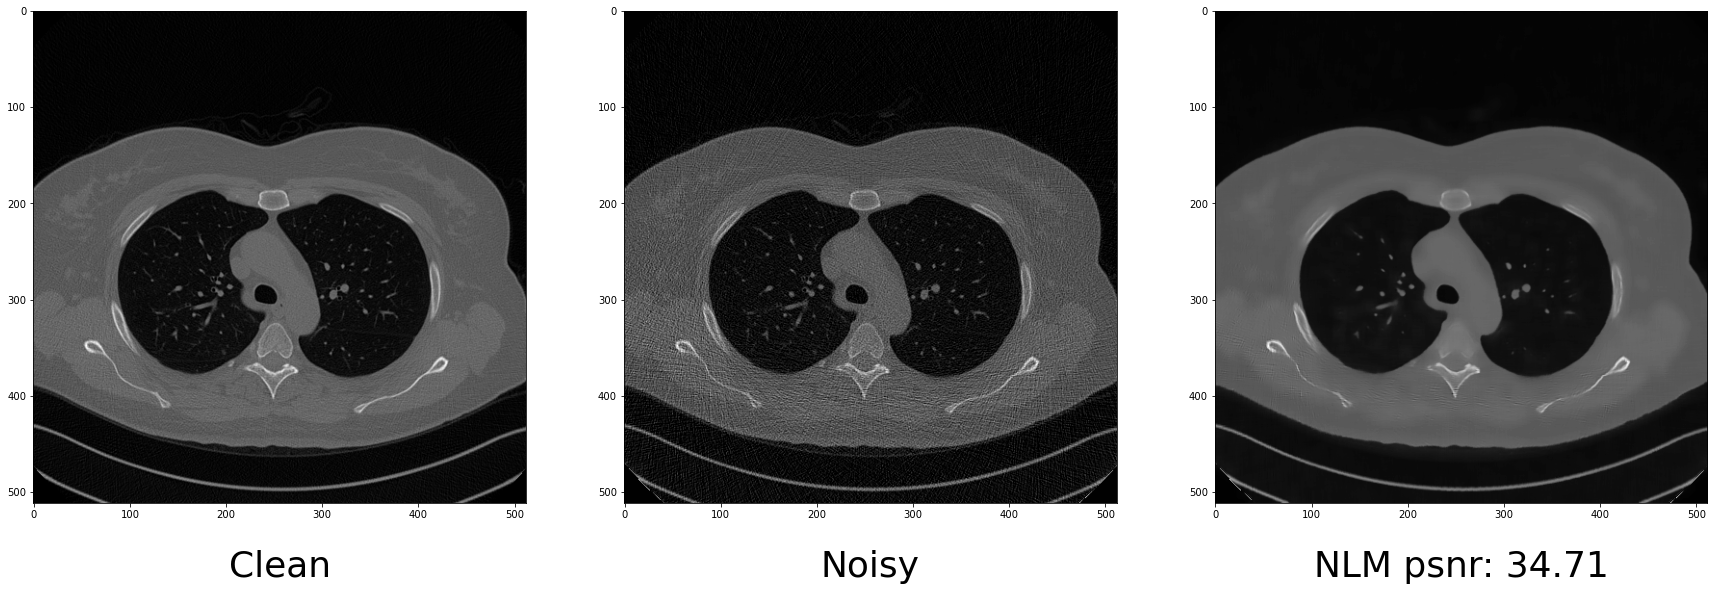

((1, 512, 512), dtype('float32'), 0.65245664, 0.0)

In [9]:
# Run Non-Local-Means
denoised_img = non_local_means(data_dict[CORRUPTED].img, sigma=SIGMA)
data_dict[NLM] = Data(denoised_img, compare_psnr(data_dict[ORIGINAL].img, denoised_img))
plot_dict(data_dict)
denoised_img.shape, denoised_img.dtype, np.max(denoised_img), np.min(denoised_img)

# Deep Learning Powered by RED, Our Generic Function
## The RED engine with Neural Network
### you may test it with any neural net, and any denoiser

In [10]:
def train_via_admm(net, net_input, denoiser_function, y, org_img=None,                      # y is the noisy image
                   plot_array={}, algorithm_name="", admm_iter=6000, save_path="",           # path to save params
                   LR=0.008,                                                                      # learning rate
                   sigma_f=3, update_iter=10, method='grad',   # method: 'fixed_point' or 'grad' or 'mixed'
                   beta=.5, mu=.5, LR_x=None, noise_factor=0.033,        # LR_x needed only if method!=fixed_point
                   threshold=20, threshold_step=0.01, increase_reg=0.03):                # increase regularization 
    """ training the network using
        ## Must Params ##
        net                 - the network to be trained
        net_input           - the network input
        denoiser_function   - an external denoiser function, used as black box, this function
                              must get numpy noisy image, and return numpy denoised image
        y                   - the noisy image
        sigma               - the noise level (int 0-255)
        
        # optional params #
        org_img             - the original image if exist for psnr compare only, or None (default)
        plot_array          - prints params at the begging of the training and plot images at the required indices
        admm_iter           - total number of admm epoch
        LR                  - the lr of the network in admm (step 2)
        sigma_f             - the sigma to send the denoiser function
        update_iter         - denoised image updated every 'update_iter' iteration
        method              - 'fixed_point' or 'grad' or 'mixed' 
        algorithm_name      - the name that would show up while running, just to know what we are running ;)
                
        # equation params #  
        beta                - regularization parameter (lambda in the article)
        mu                  - ADMM parameter
        LR_x                - learning rate of the parameter x, needed only if method!=fixed point
        # more
        noise_factor       - the amount of noise added to the input of the network
        threshold          - when the image become close to the noisy image at this psnr
        increase_reg       - we going to increase regularization by this amount
        threshold_step     - and keep increasing it every step
    """
    # get optimizer and loss function:
    mse = torch.nn.MSELoss().type(dtype)  # using MSE loss
    # additional noise added to the input:
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()
    if org_img is not None:
        psnr_y = compare_psnr(org_img, y)  # get the noisy image psnr
    # x update method:
    if method == 'fixed_point':
        swap_iter = admm_iter + 1
        LR_x = None
    elif method == 'grad':
        swap_iter = -1
    elif method == 'mixed':
        swap_iter = admm_iter // 2
    else:
        assert False, "method can be 'fixed_point' or 'grad' or 'mixed' only "
    
    # optimizer and scheduler
    optimizer = torch.optim.Adam(net.parameters(), lr=LR)  # using ADAM opt
    
    y_torch = np_to_torch(y).type(dtype)
    x, u = y.copy(), np.zeros_like(y)
    #f_x, avg, avg2, avg3 = x.copy(), np.rint(y), np.rint(y), np.rint(y)
    f_x, avg, avg2, avg3 = x.copy(), np.array(y), np.array(y), np.array(y)
    img_queue = queue.Queue()
    denoiser_thread = Thread(target=lambda q, f, f_args: q.put(f(*f_args)),
                             args=(img_queue, denoiser_function, [x.copy(), sigma_f]))
    denoiser_thread.start()
    for i in range(1, 1 + admm_iter):
        # step 1, update network:
        optimizer.zero_grad()
        net_input = net_input_saved + (noise.normal_() * noise_factor)
        out = net(net_input)
        out_np = torch_to_np(out)
        # loss:
        loss_y = mse(out, y_torch)
        loss_x = mse(out, np_to_torch(x - u).type(dtype))
        total_loss = loss_y + mu * loss_x
        total_loss.backward()
        optimizer.step()
        # step 2, update x using a denoiser and result from step 1
        if i % update_iter == 0:  # the denoiser work in parallel
            denoiser_thread.join()
            f_x = img_queue.get()
            denoiser_thread = Thread(target=lambda q, f, f_args: q.put(f(*f_args)),
                                     args=(img_queue, denoiser_function, [x.copy(), sigma_f]))
            denoiser_thread.start()

        if i < swap_iter:
            x = 1 / (beta + mu) * (beta * f_x + mu * (out_np + u))
        else:
            x = x - LR_x * (beta * (x - f_x) + mu * (x - out_np - u))
        np.clip(x, 0, 1, out=x)  # making sure that image is in bounds

        # step 3, update u
        u = u + out_np - x

        # Averaging:
        avg = avg * .99 + out_np * .01
        # show psnrs:
        psnr_noisy = compare_psnr(out_np, y)
        if psnr_noisy > threshold:
            mu = mu + increase_reg
            beta = beta + increase_reg
            threshold += threshold_step
        if org_img is not None:
            psnr_net, psnr_avg = compare_psnr(org_img, out_np), compare_psnr(org_img, avg)
            psnr_x, psnr_x_u = compare_psnr(org_img, x), compare_psnr(org_img, x - u)
            print('\r', algorithm_name, '%04d/%04d Loss %f' % (i, admm_iter, total_loss.item()),
                  'psnrs: y: %.2f psnr_noisy: %.2f net: %.2f' % (psnr_y, psnr_noisy, psnr_net),
                  'x: %.2f x-u: %.2f avg: %.2f' % (psnr_x, psnr_x_u, psnr_avg), end='')
            if i in plot_array:  # plot images
                tmp_dict = {'Clean': Data(org_img),
                            'Noisy': Data(y, psnr_y),
                            'Net': Data(out_np, psnr_net),
                            'x-u': Data(x - u, psnr_x_u),
                            'avg': Data(avg, psnr_avg),
                            'x': Data(x, psnr_x),
                            'u': Data((u - np.min(u)) / (np.max(u) - np.min(u)))
                            }
                plot_dict(tmp_dict)
        else:
            print('\r', algorithm_name, 'iteration %04d/%04d Loss %f' % (i, admm_iter, total_loss.item()), end='')
    
    if denoiser_thread.is_alive():
        denoiser_thread.join()  # joining the thread
    return avg

## Let's Go:

D:\anaconda3\envs\deep-image-prior\lib\site-packages\ipykernel_launcher.py:42: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
D:\anaconda3\envs\deep-image-prior\lib\site-packages\ipykernel_launcher.py:96: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
D:\anaconda3\envs\deep-image-prior\lib\site-packages\ipykernel_launcher.py:102: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
D:\anaconda3\envs\deep-image-prior\lib\site-packages\ipykernel_launcher.py:103: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


 DRED (NLM) 0001/6000 Loss 0.230556 psnrs: y: 28.71 psnr_noisy: 8.13 net: 8.08 x: 28.70 x-u: 8.18 avg: 16.00

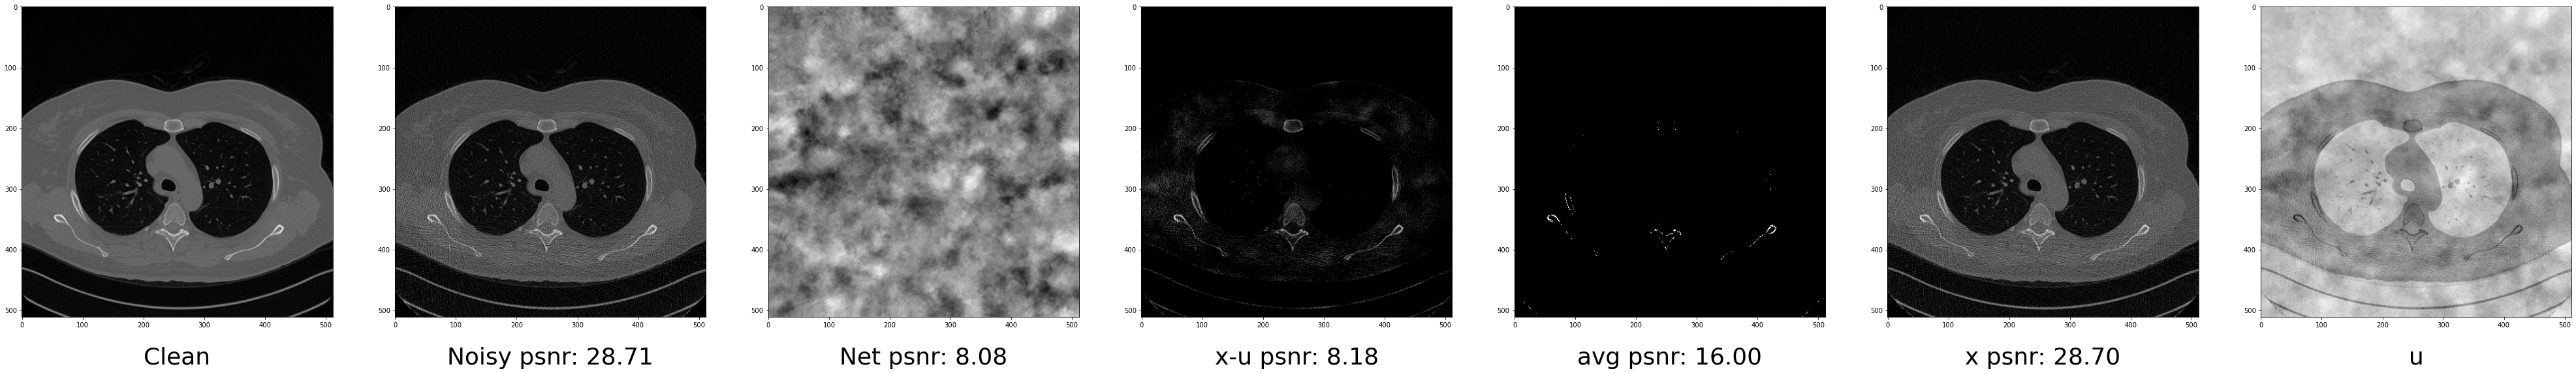

 DRED (NLM) 0010/6000 Loss 1.557442 psnrs: y: 28.71 psnr_noisy: 20.41 net: 20.83 x: 23.98 x-u: -4.37 avg: 16.91

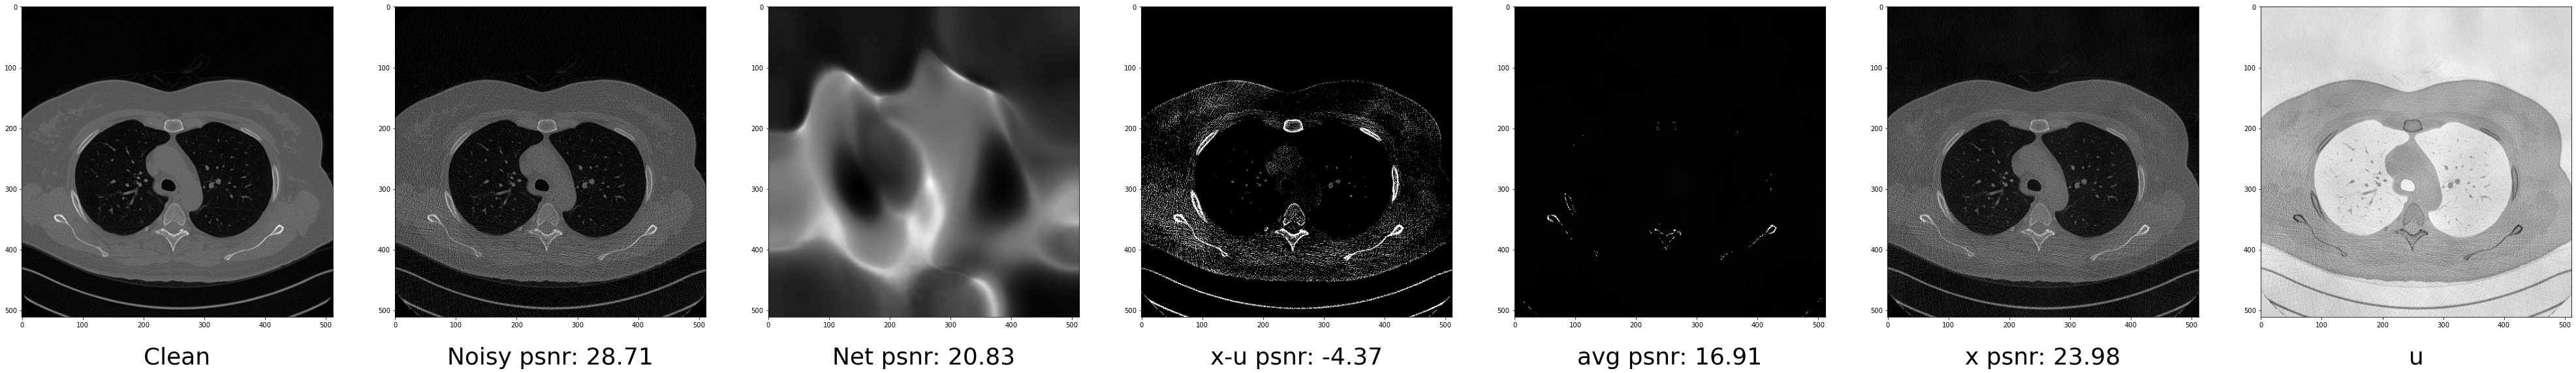

 DRED (NLM) 0050/6000 Loss 0.296967 psnrs: y: 28.71 psnr_noisy: 17.41 net: 17.60 x: 17.78 x-u: 4.58 avg: 19.443

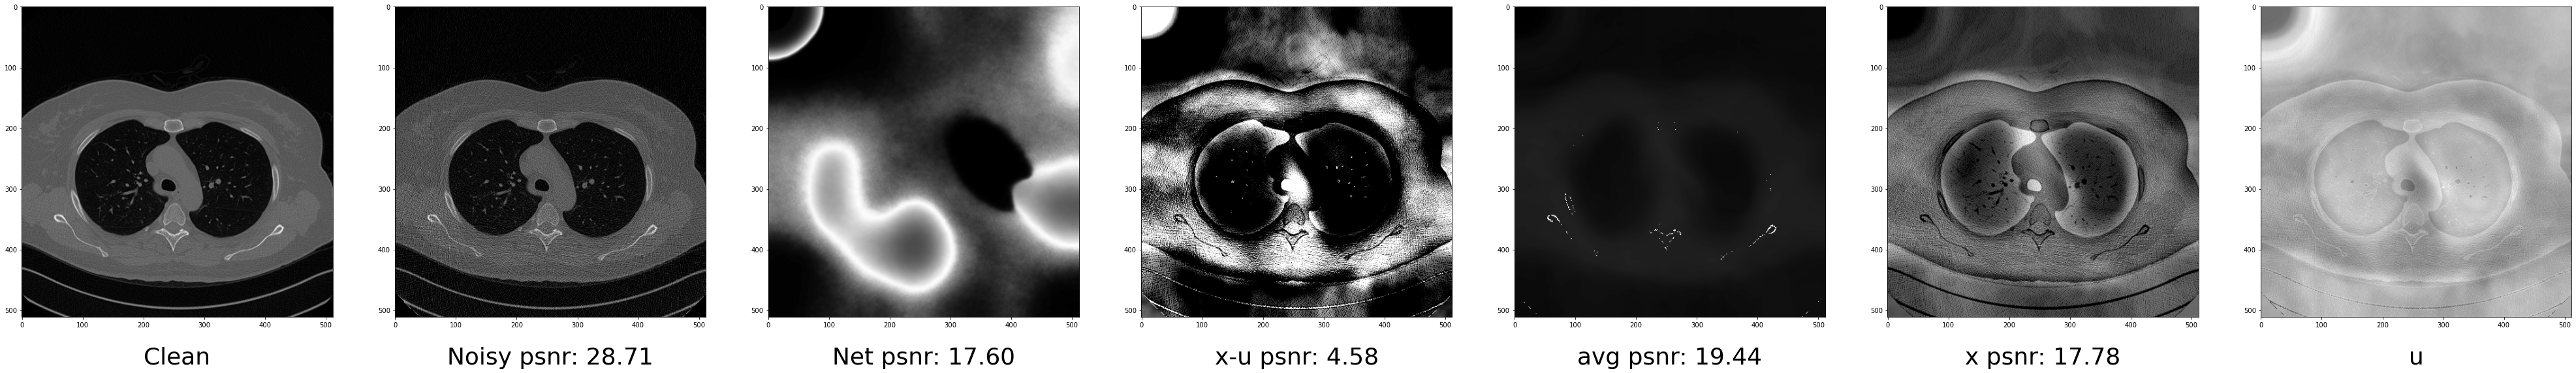

 DRED (NLM) 0094/6000 Loss 0.393917 psnrs: y: 28.71 psnr_noisy: 18.79 net: 19.02 x: 18.94 x-u: 3.96 avg: 20.21

KeyboardInterrupt: 

In [12]:
def run_and_plot(denoiser, name, plot_checkpoints={}):
    global data_dict
    net, net_input = get_network_and_input(img_shape=data_dict[CORRUPTED].img.shape)
    denoised_img = train_via_admm(net, net_input, denoiser, data_dict[CORRUPTED].img,
                                  plot_array=plot_checkpoints, algorithm_name=name,
                                  org_img=data_dict[ORIGINAL].img)
    data_dict[name] = Data(denoised_img, compare_psnr(data_dict[ORIGINAL].img, denoised_img))
    plot_dict(data_dict)


plot_checkpoints = {1, 10, 50, 100, 250, 500, 2000, 3500, 5000} 
run_and_plot(non_local_means, DIP_NLM, plot_checkpoints)  # you may try it with different denoisers

In [22]:
torch.cuda.empty_cache()
torch.cuda.memory_allocated(device=None)

1173982720